In [1]:
### Import required libraries ###
# FYI: this notebook requires {CausalImpact}, {TSclust} & {tidyr}
library(CausalImpact)
library(TSclust)

Loading required package: bsts

Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xts


Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn


Loading required package: pdc

Loading required package: cluster

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
### Import the original dataset and prerprocess ###

# CSV file from Toyo Keizai's COVID-19 dashboard
d <- read.csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/prefectures.csv')

#  Choose columns including year, month, day, prefecture (region), and cumulative positive cases
d1 <- d[, c(1, 2, 3, 5, 6)]
# The data from 2021-12-31 is to be used
d2 <- d1[33136:nrow(d1), ]
# Long to Wide
d3 <- tidyr::pivot_wider(d2, id_cols = NULL, names_from = prefectureNameE, values_from = testedPositive)
d3 <- as.data.frame(d3)
# Convert from cumulative number to daily number
diff_d3 <- diff(as.matrix(d3[, -c(1, 2, 3)]))
df <- cbind(d3[2:nrow(d3), c(1, 2, 3)], diff_d3)

In [3]:
### Normalize function, [0, 1] ###

nrm <- function(d){
  mx <- max(d)
  mn <- min(d)
  out <- (d - mn) / (mx - mn)
  return(out)
}

In [4]:
### Normalize the dataset ###

tmp <- apply(df[, -c(1:3)], 2, nrm)
df_nrm <- df
df_nrm[, -c(1:3)] <- tmp

In [5]:
### Choose regions where Manbou was declared on 2022-01-27 and ones without Manbou

df_4th <- df_nrm[, c(15, 48, 11, 17, 42, 18, 29, 41, 25, 36,
                     16, 40, 34, 10, 37, 33, 21, 19, 27, 5,
                     46, 9, 50, 39, 31, 45, 43, 8)]

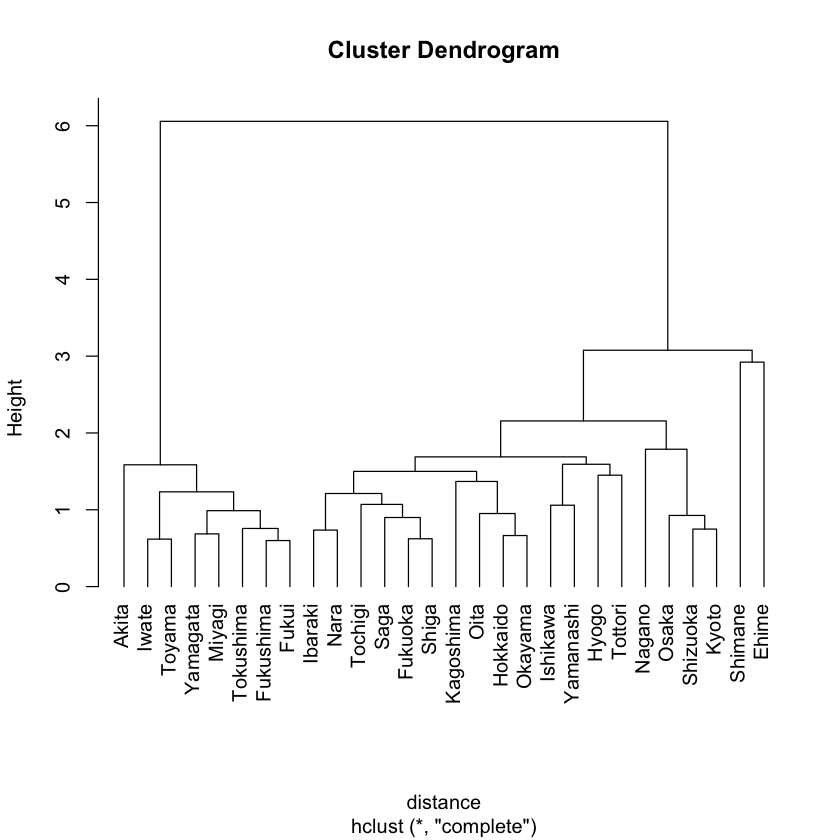

In [6]:
### In order to satisfy the parallel trend assumption, choose regions with similar trend (during pre-period) by time-series clustering

df_4th_pre <- df_4th[1:26, ]
distance <- diss(df_4th_pre, 'DTWARP')
h <- hclust(distance)
plot(h, hang = -1)

In [7]:
### Just for simplicity, arbitrarily cut them into 5 clusters

clusters <- cutree(h, 5)
print(clusters)
table(clusters)

 Hokkaido  Yamagata Fukushima   Ibaraki   Tochigi  Ishikawa    Nagano  Shizuoka 
        1         2         2         1         1         1         3         3 
    Kyoto     Osaka     Hyogo   Shimane   Okayama   Fukuoka      Saga      Oita 
        3         3         1         4         1         1         1         1 
Kagoshima     Iwate    Miyagi     Akita    Toyama     Fukui Yamanashi     Shiga 
        1         2         2         2         2         2         1         1 
     Nara   Tottori Tokushima     Ehime 
        1         1         2         5 


clusters
 1  2  3  4  5 
14  8  4  1  1 

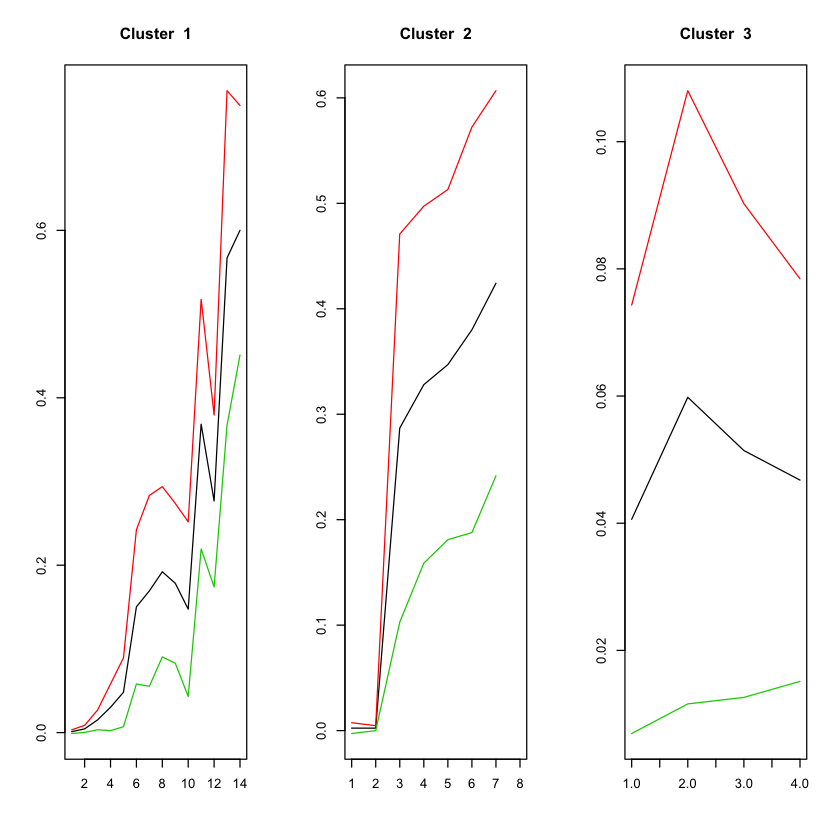

In [8]:
### Check the clusters by plotting ###

par(mfrow = c(1, 3))

# Only 1, 2, 3 clusters were chosen because 4 & 5 cluster include a single region
for (i in 1:3){
  cl_mean <- rowMeans(df_4th_pre[which(clusters == i), ])
  cl_sd <- apply(df_4th_pre[which(clusters == i), ], 1, sd)
  matplot(cbind(cl_mean, cl_mean + cl_sd, cl_mean - cl_sd),
          type = 'l', lty = 1, ylab = '')
  title(main = paste("Cluster ", i))
}

par(mfrow = c(1, 1))

In [9]:
### Choose regions with similar trends, cluster 1 ###

df_cl <- df_4th[, which(clusters == 1)]
names(df_cl)

[1] "Hokkaido"  "Ibaraki"   "Tochigi"   "Ishikawa"  "Hyogo"     "Okayama"  
 [7] "Fukuoka"   "Saga"      "Oita"      "Kagoshima" "Yamanashi" "Shiga"    
[13] "Nara"      "Tottori"

=-=-=-=-= Iteration 0 Tue Mar 15 15:22:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Mar 15 15:22:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Mar 15 15:22:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Mar 15 15:22:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Mar 15 15:22:02 2022 =-=-=-=-=
Posterior inference {CausalImpact}

                         Average        Cumulative   
Actual                   0.6            27.8         
Prediction (s.d.)        0.89 (0.22)    40.72 (9.96) 
95% CI                   [0.48, 1.4]    [21.99, 64.6]
                                                     
Absolute effect (s.d.)   -0.28 (0.22)   -12.95 (9.96)
95% CI                   [-0.8, 0.13]   [-36.9, 5.78

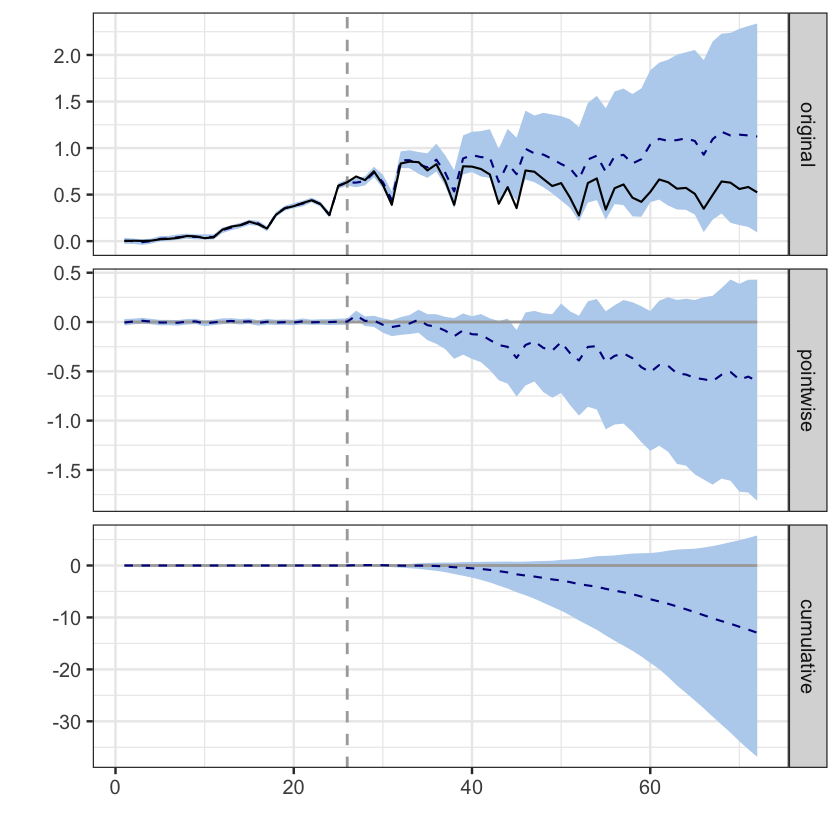

In [10]:
### Split the regions into test and control groups, and run CausalImpact ###

# Split the regions
test_cl <- df_4th[, 1:10]
ctrl_cl <- df_4th[, 11:14]

# Set pre & post period
pre.period <- c(1L, 26L)
post.period <- c(27L, nrow(df))

# Preprocess for BSTS modeling
y <- rowMeans(test_cl)
post.period.response <- y[post.period[1] : post.period[2]]
y[post.period[1] : post.period[2]] <- NA

# Run BSTS
ss <- AddLocalLinearTrend(list(), y)
ss <- AddSeasonal(ss, y, nseasons = 7)
bsts.model <- bsts(y ~ as.matrix(ctrl_cl), ss, niter = 1000)

# Run CausalImpact with the BSTS model
ci <- CausalImpact(bsts.model = bsts.model,
                    post.period.response = post.period.response)

# Show the result
print(ci)
plot(ci)